In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.enable_eager_execution()
tfe = tf.contrib.eager

print(tf.__version__)

W0506 01:11:43.064344 140735952987008 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



1.14.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

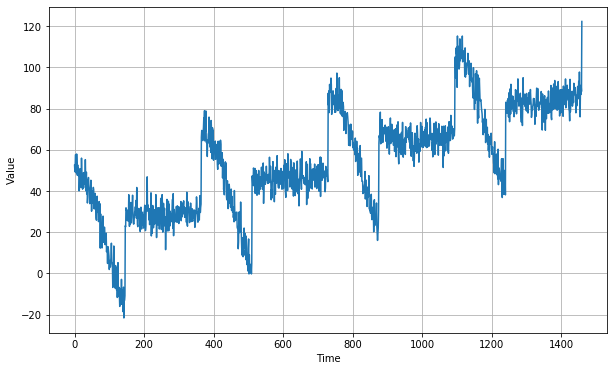

In [4]:

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()



In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]



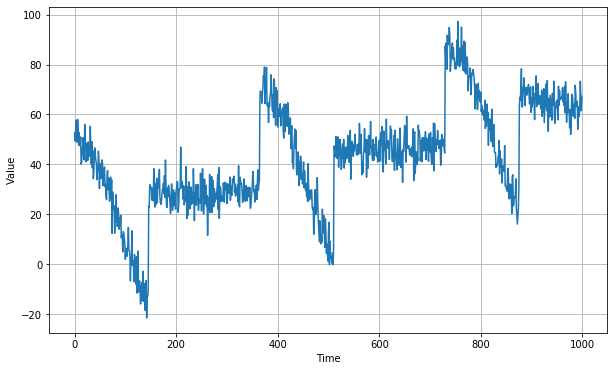

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()


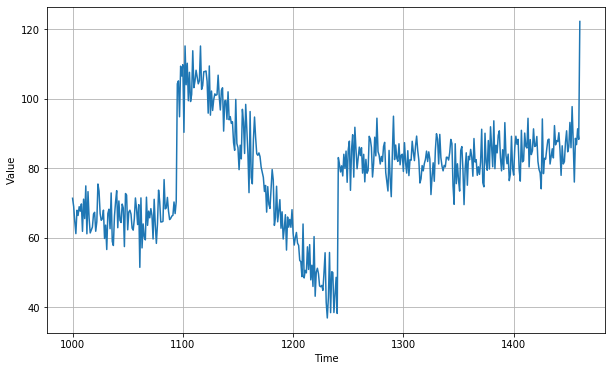

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()


In [11]:
shuffle_buffer_size = 1000
window_size = 20
batch_size = 32

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)



In [6]:
layer0 = tf.keras.layers.Dense(1, input_shape=[window_size])
#print (layer0.get_weights())

In [7]:
model = tf.keras.models.Sequential()
model.add(layer0)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=100)





Epoch 1/100
31/31 [==============================] - 0s 15ms/step - loss: 271.8151
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 118.4538
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 109.6271
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 103.8238
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 99.6807
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 96.1047
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 93.0058
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 90.2456
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 87.7528
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 85.4774
Epoch 11/100
31/31 [==============================] - 0s 7ms/step - loss: 83.3850
Epoch 12/100
31/31 [==============================] - 0s 7ms/step - loss: 81.4502
Epoch 13/100
31/31 [

In [8]:
print("Layer weights {}".format(layer0.get_weights()))

Layer weights [array([[ 0.0364802 ],
       [-0.08186308],
       [ 0.0496109 ],
       [-0.08517206],
       [ 0.14645761],
       [-0.05142049],
       [-0.06951068],
       [-0.01458752],
       [ 0.09087033],
       [ 0.02464955],
       [ 0.0257812 ],
       [-0.12194521],
       [-0.01857146],
       [ 0.05999137],
       [ 0.03599414],
       [ 0.02817307],
       [ 0.09377868],
       [ 0.12811473],
       [ 0.24856205],
       [ 0.45894545]], dtype=float32), array([0.0137916], dtype=float32)]


![image.png](./image/weights.png)

![image.png](./image/linearModel.png)

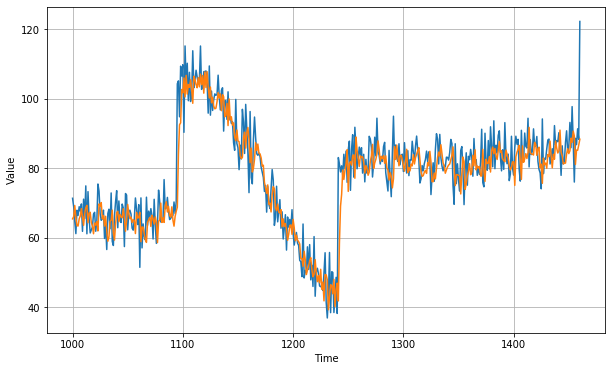

In [9]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.983565

In [11]:
history_dict = history.history

In [16]:
history.params

{'batch_size': None,
 'epochs': 100,
 'steps': 31,
 'samples': None,
 'verbose': 1,
 'do_validation': False,
 'metrics': ['loss']}

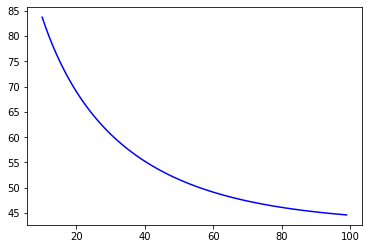

In [13]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
#print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()